## Assignment -3
##  Deep Learning - AI5100
## Author - Sarvesh Purohit
##                AI22MTECH14006 
##                MTech AI ,Department Of AI

In [123]:
import math
import random
import scipy as sc
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.models import ResNet50_Weights,resnet50
from torchvision.utils import make_grid

import skimage
import tkinter as tk
from PIL import Image,ImageSequence
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation


# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

#Q-1. Variants of Backprop for visualizing CNNs

In [124]:
#Taking images as input
img1  = Image.open("i1.jpg")
img2  = Image.open("i2.jpg")
img3  = Image.open("i3.jpg")
img4  = Image.open("i4.jpg")
img5  = Image.open("i5.jpg")

In [125]:
#Image Preprocessing
#For transformation of image
transform = transforms.Compose([       
#  transforms.Resize(224),                   
#  transforms.CenterCrop(224),                
 transforms.ToTensor(),                     
 transforms.Normalize(                     
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])

In [126]:
#Performing transformation on images
img_transformed1 = transform(img1) 
img_transformed2 = transform(img2)
img_transformed3 = transform(img3)
img_transformed4 = transform(img4)
img_transformed5 = transform(img5)

## Vanila Backpropagation

In [127]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [128]:
def vanila_backpropagation(img):
  
  img_input_model  =img.unsqueeze(0) #adding batch dim to the image 
  img_input_model.requires_grad_(True) #setting requires_grad_(True) for input

  #forward propagation
  pred = resnet(img_input_model)
  max_pred_index = torch.argmax(pred)
  max_pred =pred[0,max_pred_index] 

  #BackPropogation
  resnet.zero_grad()
  max_pred.backward(retain_graph=True)
  result= img_input_model.grad  #Storing gradient of input layer
  result =result.squeeze(0)     #removing Batch dim from gradient
  
  #Performing min max normalization
  min_max_result = (result - result.min())/(result.max()-result.min())
  img = (img - img.min())/(img.max()-img.min())
  
  #Plotting the original image and vanila_backpropagation result
  fig, ax = plt.subplots(1, 2,figsize=(10, 10))
  ax[0].imshow(img.detach().numpy().transpose(1, 2, 0))
  ax[0].axis('off')
  ax[1].imshow((min_max_result.numpy().transpose(1, 2, 0)), cmap='hot')
  ax[1].axis('off')
  plt.tight_layout()
  plt.show()  

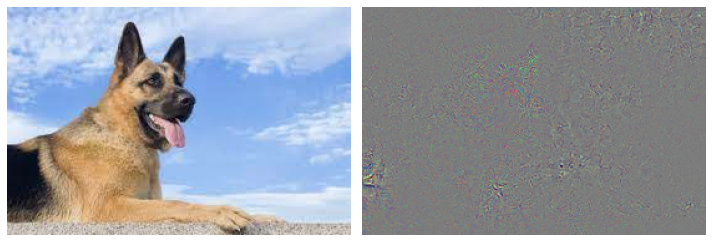

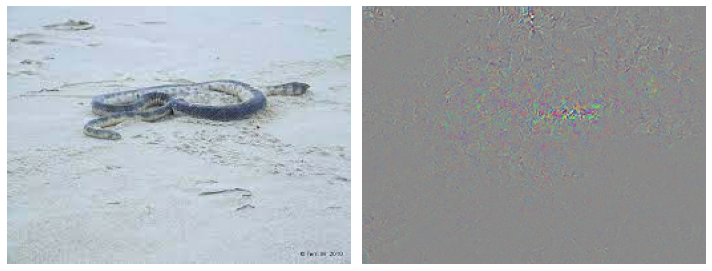

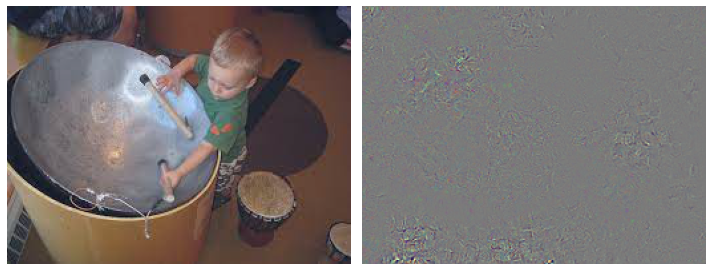

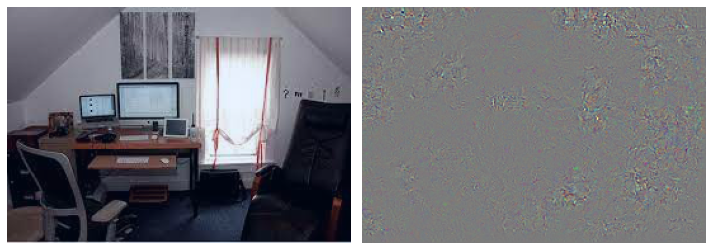

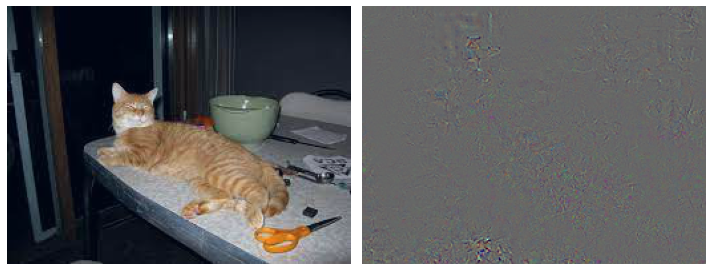

In [129]:
vanila_backpropagation(img_transformed1)
vanila_backpropagation(img_transformed2)
vanila_backpropagation(img_transformed3)
vanila_backpropagation(img_transformed4)
vanila_backpropagation(img_transformed5)

## Guided-back-propagation

In [130]:
#Defining hook function for applying relu once again after taking gradinet W.R.T to relu while performing backpropagation  
def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.),)

In [131]:
#Registering above function as backward hook on each relu layer on resnet50
resnet.zero_grad()
for i, module in enumerate(resnet.modules()):
    if isinstance(module, torch.nn.ReLU):
        module.register_backward_hook(relu_hook_function)

In [132]:
guided_bpro = [] #This list will store guided back propagation result because we will use it again in Guided Grad-CAM

def guided_back_prop(img):

  global guided_bpro
  img_input_model  =img.unsqueeze(0) #adding batch dim
  img_input_model.requires_grad_(True)
  
  #Forward Pass
  pred = resnet(img_input_model)
  max_pred_index = torch.argmax(pred)
  max_pred =pred[0,max_pred_index]
  max_pred.backward(retain_graph=True)

  #BackPropogation
  result= img_input_model.grad
  result =result.squeeze(0) #removing batch dim
  guided_bpro.append(result.numpy())

  #Performing min max normalization
  min_max_result = (result - result.min())/(result.max()-result.min())
  img = (img - img.min())/(img.max()-img.min())
  
  #Plotting the original image and Guided-back-propagation result
  fig, ax = plt.subplots(1, 2,figsize=(10, 10))
  ax[0].imshow(img.detach().numpy().transpose(1, 2, 0))
  ax[0].axis('off')
  ax[1].imshow((min_max_result.numpy().transpose(1, 2, 0)), cmap='hot')
  ax[1].axis('off')
  plt.tight_layout()
  plt.show()  

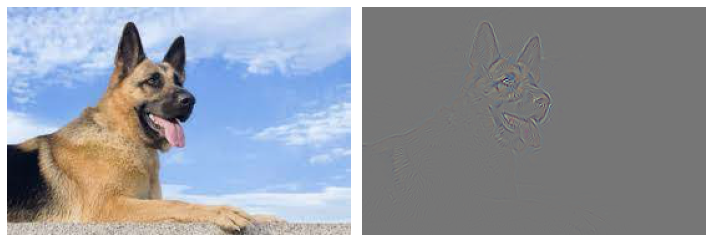

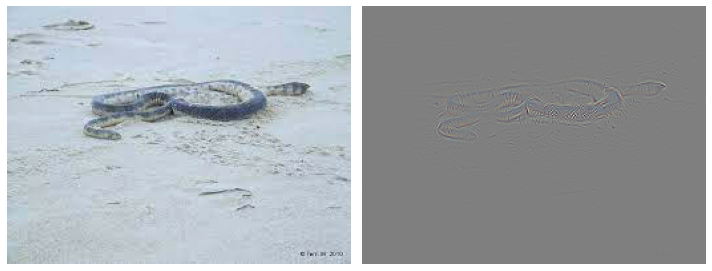

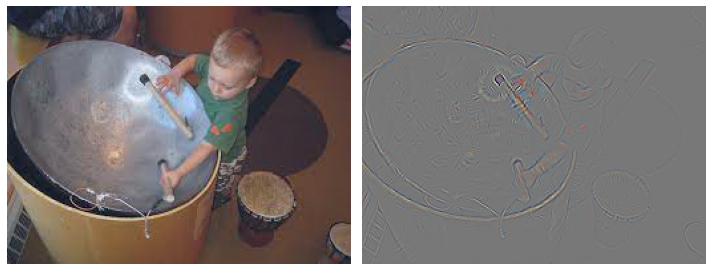

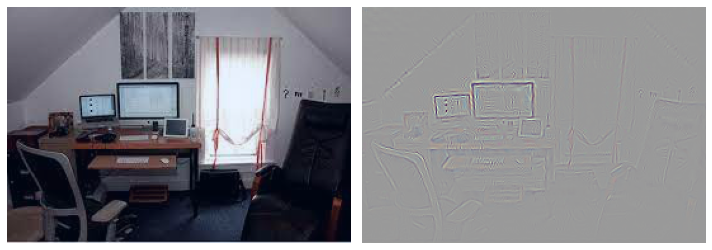

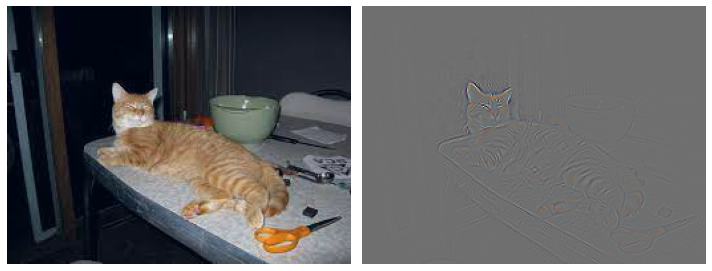

In [133]:
guided_back_prop(img_transformed1)
guided_back_prop(img_transformed2)
guided_back_prop(img_transformed3)
guided_back_prop(img_transformed4)
guided_back_prop(img_transformed5)

## Class Activatoin Map (CAM)

In [134]:
resnet1 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
resnet1.eval()
target_layer = resnet1.layer4[-1].relu

In [135]:
#Defining forward hook to catch the activation map on last relu layer
outputs = []
def hook_forward_CAM(module, input, output):
    global outputs
    outputs = output

handle = target_layer.register_forward_hook(hook_forward_CAM)

In [136]:
def CAM(img):
  
  img_input_model  =img.unsqueeze(0) #adding batch dim

  #Forward Pass
  pred_CAM = resnet1(img_input_model) 
  output_cam =outputs.squeeze(0) #removing batch size from the activation map that we have catched in forward hook
  max_pred_index_cam = torch.argmax(pred_CAM)

  #fetching the weights values associated to the predicated class's neuron and GAP layer
  weight_cam =resnet.fc.weight[max_pred_index_cam]

  #weighted sum of the last layer activation map
  cam = torch.zeros(output_cam.shape[1],output_cam.shape[2])
  for i in range(2048):
    cam += torch.multiply(weight_cam[i],output_cam[i,:,:])
  
  #Performing min max normalization
  cam = (cam - cam.min())/(cam.max()-cam.min())
  img = (img - img.min())/(img.max()-img.min())

  #Plotting the original image and Guided-back-propagation result
  fig, ax = plt.subplots(1, 3,figsize=(15, 15))
  ax[0].imshow(img.detach().numpy().transpose(1, 2, 0))
  ax[0].axis('off')
  cam = cam.detach().numpy()
  cam = skimage.transform.resize(cam,(img.shape[1],img.shape[2]))
  ax[1].imshow(cam,cmap ='hot')
  ax[1].axis('off')
  ax[2].imshow(img.detach().numpy().transpose(1, 2, 0))
  ax[2].imshow(cam,alpha=0.8,cmap ='hot')
  ax[2].axis('off')
  plt.tight_layout()
  plt.show()  

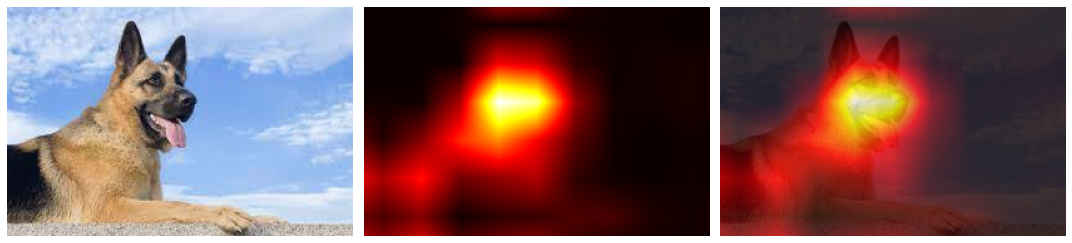

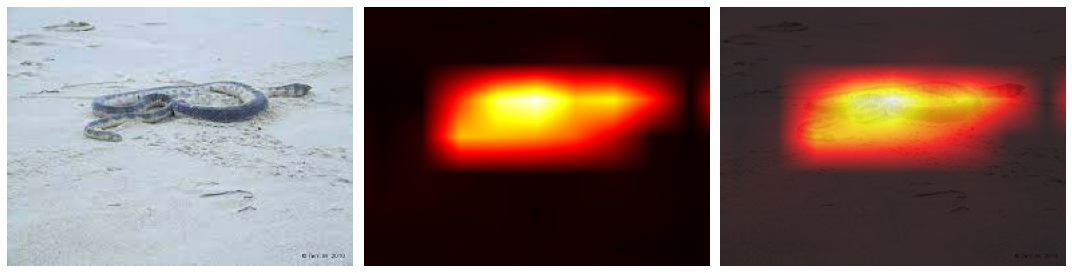

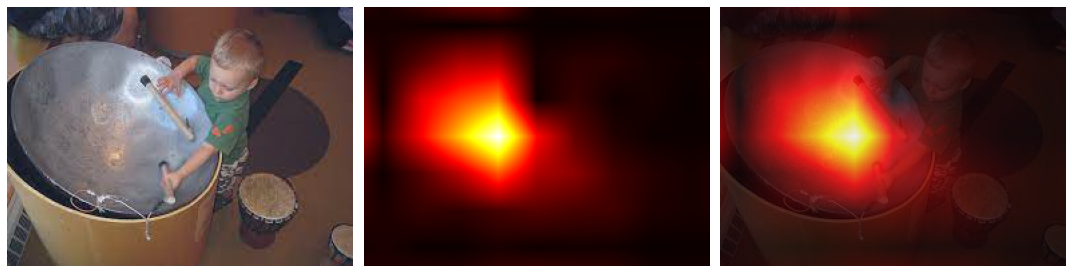

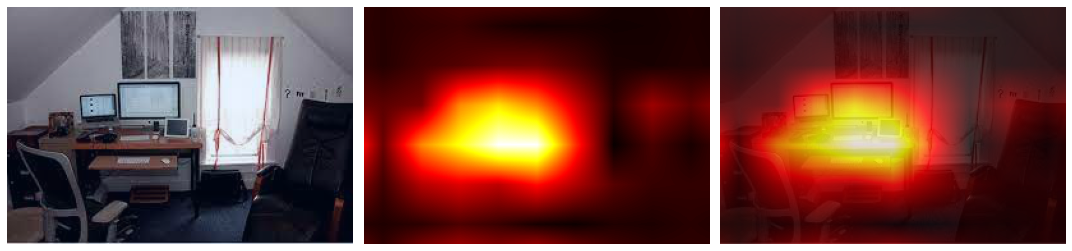

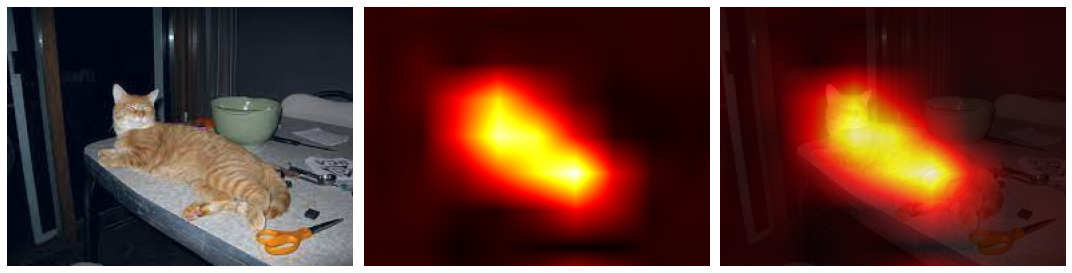

In [137]:
CAM(img_transformed1)
CAM(img_transformed2)
CAM(img_transformed3)
CAM(img_transformed4)
CAM(img_transformed5)

### Guided Grad-CAM

In [138]:
resnet2 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
resnet2.eval()

resnet2.requires_grad_()
target_layer = resnet2.layer4[-1].relu

In [139]:
#Defining forward hook to catch the activation map on last relu layer
forward_activation=[]
def hook_forward_gCAM(module, input, output):
    global forward_activation
    forward_activation = output

#Defining backward hook to catch the gradient of last relu layer
grad=[]
def hook_backward_gCAM(module,grad_in,grad_out):
  global grad
  grad = grad_out[0]

target_layer.register_forward_hook(hook_forward_gCAM)
target_layer.register_forward_hook(hook_backward_gCAM)

In [140]:
def guided_gCAM(img,j):
    
  img_input_model  =img.unsqueeze(0) #adding batch dim
  
  pred_gCAM = resnet2(img_input_model) #forward pass
  max_pred_index = torch.argmax(pred_gCAM)
  max_pred =pred_gCAM[0,max_pred_index]

  #backward pass
  resnet2.zero_grad()
  max_pred.backward(retain_graph=True)

  #catching activation and gradient stored in hook
  activation_gcam =forward_activation.squeeze(0)  #removing batch size from the result that we have catched in forward hook
  gradient_gcam = grad.squeeze(0)
  gradient_gcam = (gradient_gcam - gradient_gcam.min())/(gradient_gcam.max()-gradient_gcam.min())

  #Finding GAP weights by taking mean of last layer relu's gradient across each channel  
  weights = torch.zeros(gradient_gcam.shape[0])
  for i in range(2048):
    weights[i] = torch.mean(gradient_gcam[i,:,:])

  #weighted sum of the last layer activation map using above calculated weights
  gcam = torch.zeros(activation_gcam.shape[1],activation_gcam.shape[2])
  for i in range(2048):
    gcam += torch.multiply(weights[i],activation_gcam[i,:,:])

  #applying Relu 
  gcam = F.relu(gcam)

  #resizing gcam to the original image size
  gcam = skimage.transform.resize(gcam.detach().numpy(),(img.shape[1],img.shape[2]))
  
  for i in range(3):
    temp = guided_bpro[j-1]
    # temp = (temp - temp.min())/(temp.max()-temp.min())
    temp[i,:,:] = temp[i,:,:] * gcam
  
  #Performing min max normalization
  min_max_result = (temp - temp.min())/(temp.max()-temp.min())
  img = (img - img.min())/(img.max()-img.min())

  fig, ax = plt.subplots(1, 2,figsize=(10, 10))
  ax[0].imshow(img.detach().numpy().transpose(1, 2, 0))
  ax[0].axis('off')
  ax[1].imshow(min_max_result.transpose(1, 2, 0))
  ax[1].axis('off')
  plt.tight_layout()
  plt.show()   

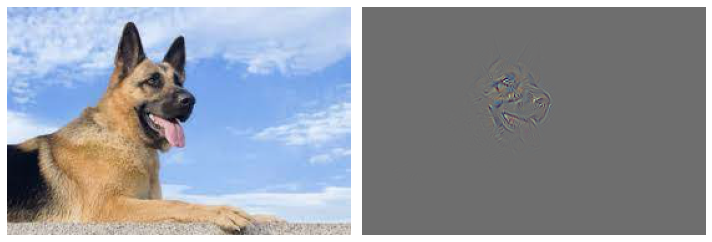

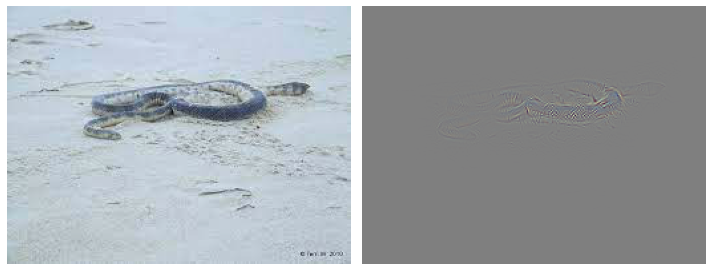

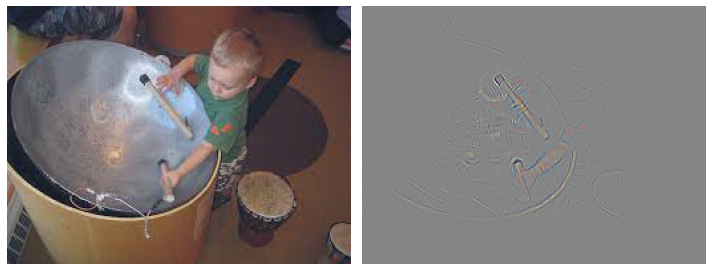

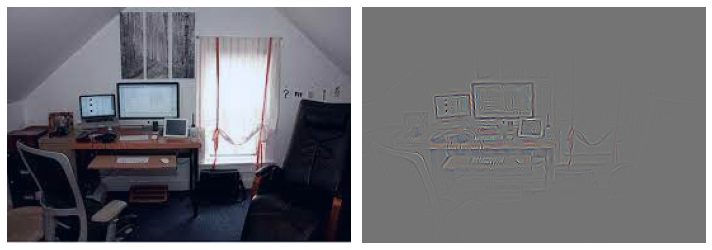

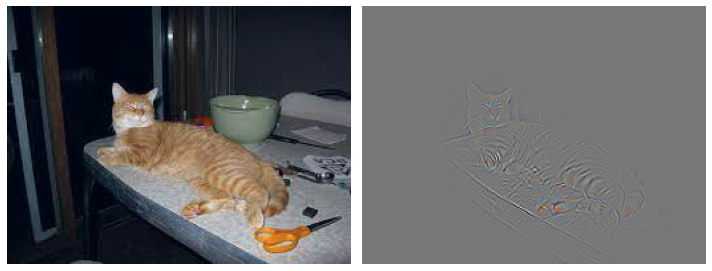

In [150]:
guided_gCAM(img_transformed1,1)
guided_gCAM(img_transformed2,2)
guided_gCAM(img_transformed3,3)
guided_gCAM(img_transformed4,4)
guided_gCAM(img_transformed5,5)

# **Q-2 SGD Update rule variations**

* *Defining the function to minimize*

In [142]:
def f(x, y):
    return 10 * x**2 + y**2

* Defining Derivative of f(x,y) w.r.t of both variable x and y

In [143]:
def grad_f(x, y):
    return (20*x, 2*y)

* *First, visualising the f(x,y) in (-20,20) and (-20,20) region*

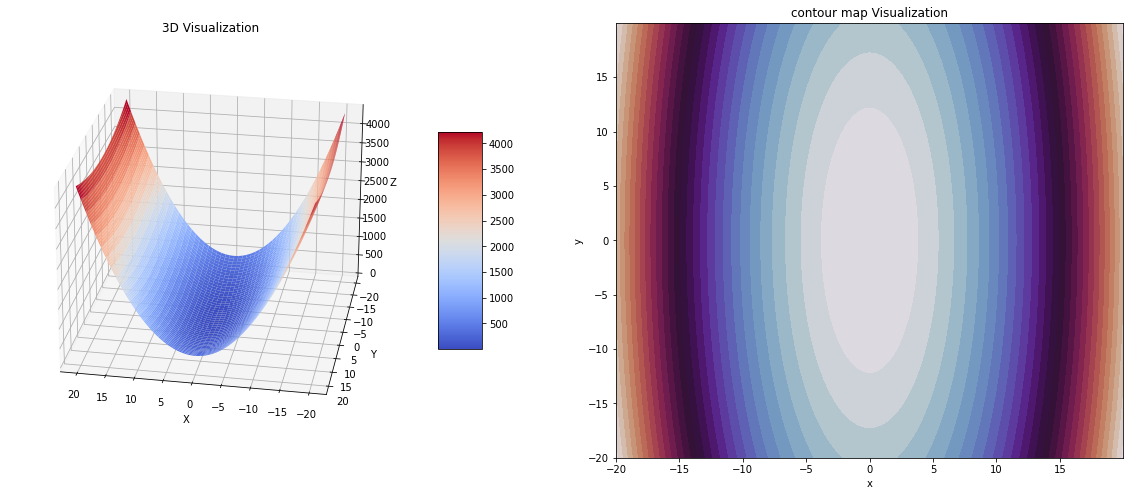

In [144]:
# Domain of function
x = np.arange(-20, 20, 0.01)
y = np.arange(-20, 20, 0.01)

# Creating (x, y) pairs and calculating Z coordiante
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure(figsize = (20, 8))
ax = fig.add_subplot(1, 2, 1, projection = '3d')
surf = ax.plot_surface(X, Y, Z, cmap = cm.coolwarm)
ax.view_init(25, 100)
ax.set_title('3D Visualization')
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
fig.colorbar(surf, shrink=0.5, aspect=5)
             
ax1 = fig.add_subplot(1, 2, 2)
plt.title('contour map Visualization')
plt.contourf(X, Y, Z, levels = 30, cmap = 'twilight')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

#### Vanilla SGD

In [145]:
vanilla_path = []
x, y = 12,12
learning_rate = 0.04
epoch = 50

for i in range(epoch):
    grad_x, grad_y = grad_f(x, y)
    
    x -= learning_rate * grad_x
    y -= learning_rate * grad_y
    vanilla_path.append([x,y])

print("for vanilla SGD is Minimum value of f(x,y): ",round(f(x,y),4) ,"obtained at x =", round(x,4), "and y =",round(y,4))

for vanilla SGD is Minimum value of f(x,y):  0.0344 obtained at x = 0.0 and y = 0.1856


#### SGD with momentum

In [146]:
SGD_momentum_path = []
x, y = 12,12
learning_rate = 0.01
epoch = 50
momentum = 0.9

# initializing velocity
vx, vy = 0, 0

for i in range(epoch):
    grad_x, grad_y = grad_f(x, y)
    
    # update the velocity using momentum
    vx = momentum*vx + learning_rate*grad_x
    vy = momentum*vy + learning_rate*grad_y
    
    # updating the parameters
    x -= vx
    y -= vy

    SGD_momentum_path.append([x,y])

print("for SGD with momentum Minimum value of f(x,y):",round(f(x,y),4) ,"obtained at x =", round(x,4), "and y =",round(y,4))

for SGD with momentum Minimum value of f(x,y): 2.1266 obtained at x = -0.366 and y = 0.8873


### Nesterov Momentum

In [147]:
Nesterov_Momentum_path = []
x, y = 12,12
learning_rate = 0.01
epoch = 50
momentum = 0.9

# initialize the velocity
vx, vy = 0, 0

for i in range(epoch):
    # compute the gradient at the lookahead point
    lookahead_x = x + momentum*vx
    lookahead_y = y + momentum*vy
    grad_x, grad_y = grad_f(lookahead_x, lookahead_y)
    
    # update the velocity using Nesterov Momentum
    vx = momentum*vx - learning_rate*grad_x
    vy = momentum*vy - learning_rate*grad_y
    
    # update the parameters
    x += vx
    y += vy

    Nesterov_Momentum_path.append([x,y])

print(" for Nesterov Momentum Minimum value of f(x,y):",round(f(x,y),4) ,"obtained at x =", round(x,4), "and y =",round(y,4))

 for Nesterov Momentum Minimum value of f(x,y): 0.3114 obtained at x = -0.0019 and y = 0.558


### AdaGrad

In [148]:
AdaGrad_path = []
x, y = 12,12
learning_rate = 1.9
epoch = 50
momentum = 0.9
eps = 1e-8

# initialize the sum of squared gradients
squared_g_sum_x, squared_g_sum_y = 0, 0


for i in range(epoch):
    # compute the gradient of the function at the current point
    g_x, g_y = grad_f(x, y)
    
    # update the sum of squared gradients
    squared_g_sum_x += g_x**2
    squared_g_sum_y += g_y**2
    
    # update the parameters using AdaGrad
    x -= learning_rate*g_x / (np.sqrt(squared_g_sum_x) + eps)
    y -= learning_rate*g_y / (np.sqrt(squared_g_sum_y) + eps)

    AdaGrad_path.append([x,y])

print("For AdaGrad Minimum value of f(x,y) is",round(f(x,y),4) ,"obtained at x =", round(x,4), "and y =",round(y,4))

For AdaGrad Minimum value of f(x,y) is 0.5157 obtained at x = 0.2165 and y = 0.2165


### RMSProp

In [149]:
RMSProp_path = []
x, y = 12, 12
learning_rate = 0.4
decay_rate = 0.9
eps = 1e-7
epoch = 50

#running average of squared gradients
running_avg_sq_grad_x, running_avg_sq_grad_y = 0, 0


for i in range(epoch):
    grad_x, grad_y = grad_f(x, y)
    
    running_avg_sq_grad_x = decay_rate*running_avg_sq_grad_x + (1-decay_rate)*grad_x**2
    running_avg_sq_grad_y = decay_rate*running_avg_sq_grad_y + (1-decay_rate)*grad_y**2
    
    # update the parameters
    x -= learning_rate*grad_x / (np.sqrt(running_avg_sq_grad_x) + eps)
    y -= learning_rate*grad_y / (np.sqrt(running_avg_sq_grad_y) + eps)
   
    RMSProp_path.append([x,y])

print(" for RMSProp Minimum value of f(x,y) is",round(f(x,y),4) ,"obtained at x =", round(x,4), "and y =",round(y,4))

 for RMSProp Minimum value of f(x,y) is 0.0011 obtained at x = 0.0101 and y = 0.0101


In [ ]:
#GIF generation
x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
global checkpoint
fig, ax = plt.subplots(figsize=(10, 10))
ax.contourf(X, Y, Z, levels = 30, cmap = 'twilight')
ax.set_xlabel('x')
ax.set_ylabel('y')
labels = ['Vanilla SGD', 'Momentum SGD', 'Nestrov Momentum SGD','Adagrad SGD','RMSProp SGD']


def update(i):
    ax.plot(*vanilla_path[i], color='blue',marker='>',linestyle='dashed', linewidth=2, markersize=3)
    ax.plot(*SGD_momentum_path[i], color='green', marker='o', linestyle='dashed',linewidth=2, markersize=3)
    ax.plot(*Nesterov_Momentum_path[i], color='red', marker='o', linestyle='dashed',linewidth=2, markersize=3)
    ax.plot(*AdaGrad_path[i], color='#FFDD44', marker='o', linestyle='dashed',linewidth=2, markersize=3)
    ax.plot(*RMSProp_path[i], color='k', marker='o', linestyle='dashed',linewidth=2, markersize=3)
   
    if(i==1):
      ax.plot(*vanilla_path[i], color='blue',marker='>',linestyle='dashed', linewidth=2, markersize=3,label='vanilla')
      ax.plot(*SGD_momentum_path[i], color='green', marker='o', linestyle='dashed',linewidth=2, markersize=3,label='SGD_momentum')
      ax.plot(*Nesterov_Momentum_path[i], color='red', marker='o', linestyle='dashed',linewidth=2, markersize=3,label='Nesterov_Momentum')
      ax.plot(*AdaGrad_path[i], color='#FFDD44', marker='o', linestyle='dashed',linewidth=2, markersize=3,label='AdaGrad')
      ax.plot(*RMSProp_path[i], color='k', marker='o', linestyle='dashed',linewidth=2, markersize=3,label='RMSProp')
      ax.legend()
    return ax

ani = FuncAnimation(fig, update, frames=len(vanilla_path))
ani.save('convergence.gif', writer='pillow')

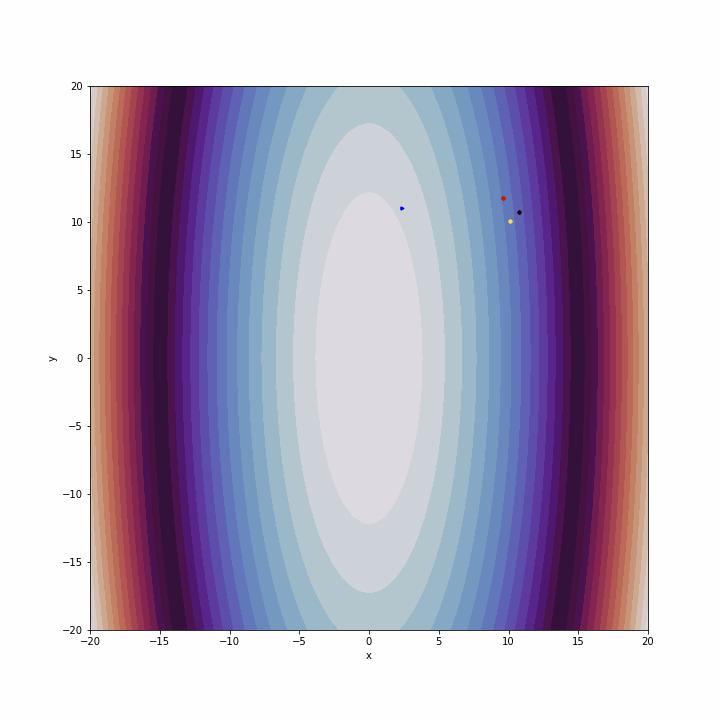

In [122]:
from IPython.display import Image
Image(open('convergence.gif','rb').read())